IMPORT LIBRARY

In [2]:
import sys, os
current_dir = os.getcwd()
project_root = current_dir[:current_dir.find("src") - 1]
sys.path.insert(0, project_root)

import pandas as pd
from data_selector import Data_selector
from feature_modifier import Feature_selector, Feature_adder
from logs.logger import CustomLogger
from models import Random_Forest, Linear
from src.root import get_root

logger = CustomLogger(name="model_main", log_file_name='model_main.log').get_logger()

READ CSV

In [11]:
def filter_time(df,date1,date2,get_bool=False):
    if get_bool:
        return (df['datetime'] >= date1) & (df['datetime'] <= date2)
    return df[(df['datetime'] >= date1) & (df['datetime'] <= date2)]

def filter_name_code(df,name,code,get_bool=False):
    mask = (df["name"] == name) & (df["code"] == code)
    if get_bool:
        return mask
    return df[mask]

def get_interval(df,l_min):
    df_s = df.reset_index(drop=True)
    gap_mask_time = df_s['datetime'].diff() != pd.Timedelta(hours=1)  # هر جایی اختلاف دقیقاً 1 ساعت نیست، مرز بازه جدید است
    gap_mask_generatiion = df_s['generation'].diff() > 4
    gap_mask = gap_mask_time | gap_mask_generatiion
    # ایندکس شروع بازه‌ها
    start_indices = df_s.index[gap_mask].tolist()
    # چون اولین ایندکس هم ابتدای یک بازه است، اگر نیست اضافه می‌کنیم
    if 0 not in start_indices:
        start_indices = [0] + start_indices
    # ایندکس پایان بازه‌ها یکی قبل از شروع بازه بعدی است
    end_indices = [i-1 for i in start_indices[1:]] + [df_s.index[-1]]
    
    for i in range(len(start_indices)-1,-1,-1):
        if end_indices[i] - start_indices[i] < l_min-1:
            end_indices.pop(i)
            start_indices.pop(i)
    # ساخت لیست بازه‌های (i1, i2)
    index_ranges = list(zip(start_indices, end_indices))
    
    # ساخت لیست بازه‌های زمانی (t1, t2)
    time_ranges = [(df_s.loc[i1, 'datetime'], df_s.loc[i2, 'datetime']) for i1, i2 in index_ranges]
    return index_ranges,time_ranges

import numpy as np
from scipy.signal import savgol_filter
import matplotlib.pyplot as plt

def is_smooth_array(data,threshold,f_show = False):
    x = data["datetime"].to_numpy()  # Your x-values
    y = data["generation"].to_numpy()  # Your y-values
    window_length = len(y) - 1 + len(y)%2  # window size, must be odd, adjust for your data
    polyorder = 3  # polynomial order
    
    y_smooth = savgol_filter(y, window_length=window_length, polyorder=polyorder)

    # Compute residual noise
    residuals = y - y_smooth
    noise_std = np.std(residuals)
    value = np.max(np.diff(y, n=1))#abs(y-y.mean())#residuals
    
    # Optional: Visualize
    if f_show:
        plt.plot(x, y, label='Raw data')
        plt.plot(x, y_smooth, label='Smoothed curve')
        plt.legend()
        plt.show()

    is_smooth = noise_std < threshold and value < 10
    return noise_std, is_smooth, value

def is_smooth(df,date1,date2,data_var,data_date,threshold,flag=False):
    slice = filter_time(df,date1,date2)[["hour","generation","datetime"]]
    if len(slice["hour"]) >= 4:
        #x,f,re = is_smooth_array(slice,threshold,flag)
        f = True
        #if data_var != None : data_var[f].append(x)
        if data_date != None : data_date[f].append((date1,date2))

def get_smooth_good_slice(df,time_ranges,threshold):
    data_var = {True:[],False:[]}
    data_date = {True:[],False:[]}
    for date1,date2 in time_ranges:
        f = (date2 - date1) >= pd.Timedelta(hours=1)
        data_date[f].append((date1,date2))
        #is_smooth(df,date1,date2,data_var,data_date,threshold)
    p = len(data_date[True])/len(data_date[True]+data_date[False])*100 if len(data_date) != 0 else None
    return p,data_var,data_date

def labeling_point(df,df_n_c,date,label):
    for date1,date2 in date:
        flag_array = filter_time(df_n_c,date1,date2,get_bool=True)
        df.loc[flag_array.index[flag_array],"is_good_pick"] = label

In [12]:
def add_change_column(df_modified):
    
    df_modified['date'] = pd.to_datetime(df_modified['date'])
    df_modified['datetime'] = df_modified['date'] + pd.to_timedelta(df_modified['hour'], unit='h')
    df_modified["temperature_change"] = None
    df_modified["generation_change"] = None
    
    power_plants = df_modified[['name', 'code']].drop_duplicates()
    n = len(power_plants)

    for _, row in power_plants.iterrows():
        #print(row["name"],row["code"])
        df_name_code_smooth = filter_name_code(df_modified,row["name"],row["code"])
        df_modified.loc[df_name_code_smooth.index,"temperature_change"] = df_name_code_smooth["temperature"].diff()
        df_modified.loc[df_name_code_smooth.index,"generation_change"] = df_name_code_smooth["generation"].diff()
    
    df_modified["temperature_change"]= df_modified["temperature_change"].astype(float)
    df_modified["generation_change"] = df_modified["generation_change"].astype(float)
    
    return df_modified.dropna().reset_index(drop=True)

def add_data_time(df):
    df['datetime'] = df['date'] + pd.to_timedelta(df['hour'], unit='h')
    
def add_is_good_pick_column(df_row):
    df_modified = df_row[["name","code","date","hour","status",'value',"generation",'season']].copy(deep=True)

    df_modified = Data_selector(df_modified).select_peaks(m_in_summer=True)

    threshold = 0.5

    df_modified['datetime'] = df_modified['date'] + pd.to_timedelta(df_modified['hour'], unit='h')
    df_row["is_good_pick"] = 0

    power_plants = df_modified[['name', 'code']].drop_duplicates()
    for _, row in power_plants.iterrows():
        df_name_code_smooth = filter_name_code(df_modified,row["name"],row["code"])
        index_ranges,time_ranges = get_interval(df_name_code_smooth,l_min=4)
        p,data_var,data_date = get_smooth_good_slice(df=df_name_code_smooth,time_ranges=time_ranges,threshold=threshold)
        print(row["name"],row["code"],p)
        labeling_point(df_row,df_name_code_smooth,data_date[False],label=1)
        labeling_point(df_row,df_name_code_smooth,data_date[True],label=2)
        
    return df_row
        

In [13]:
df_row = pd.read_csv(get_root() +"/data/processed/integrated.csv", encoding='utf-8')

In [16]:
df_name_code_smooth = filter_name_code(df_row,"پرند","G11")

In [14]:
feature_adder = Feature_adder(df_row)
feature_adder.add_season()
df_row = add_change_column(df_row)
df_row = add_is_good_pick_column(df_row)

پرند G15 100.0
پرند G16 100.0
شهدای پیروز - بهبهان S1 100.0
شهدای پیروز - بهبهان G12 100.0
جنوب اصفهان - چهلستون G15 100.0
پرند G14 100.0
سیکل ترکیبی ارومیه G13 100.0
سیکل ترکیبی ارومیه G14 100.0
سیکل ترکیبی شیروان S1 100.0
سیکل ترکیبی شیروان G11 100.0
عسلویه G15 100.0
عسلویه G14 100.0
عسلویه G16 100.0
شهدای پیروز - بهبهان G11 100.0
جنوب اصفهان - چهلستون G11 100.0
سبلان G11 100.0
سیکل ترکیبی ارومیه G16 100.0
سیکل ترکیبی ارومیه G11 100.0
سیکل ترکیبی شیروان G13 100.0
سیکل ترکیبی شیروان G12 100.0
سیکل ترکیبی شیروان S2 100.0
عسلویه G11 100.0
حافظ G11 100.0
جنوب اصفهان - چهلستون G14 100.0
جنوب اصفهان - چهلستون G16 100.0
سیکل ترکیبی ارومیه G15 100.0
سیکل ترکیبی ارومیه G12 100.0
سیکل ترکیبی شیروان G16 100.0
حافظ G16 100.0
پرند G13 100.0
سبلان G12 100.0
سیکل ترکیبی یزد G12 100.0
سبلان G16 100.0
جنوب اصفهان - چهلستون G13 100.0
پرند G12 100.0
پرند G11 100.0
جنوب اصفهان - چهلستون G12 100.0
سبلان G15 100.0
سیکل ترکیبی شیروان G14 100.0
عسلویه G12 100.0
عسلویه G13 100.0
حافظ G12 100.0
سبلان G13 100.

In [15]:
df_row.to_csv(path_or_buf=get_root() +'/data/processed/prediction_only.csv', sep=',', header=True, index=False,na_rep='NULL')

In [49]:
def create_feature_with_delay(df,feature,n_delay):
    new_feature = f"{feature}_with_{n_delay}_delay"
    df[new_feature] = None
    df = df.sort_values(by=['code', 'name', 'date', 'hour'])
    df[new_feature] = df.groupby(['code', 'name'])[feature].shift(n_delay)
    return df.dropna()

In [50]:
for i in range(1,25):
    df_row = create_feature_with_delay(df_row,"temperature_change",i)

In [51]:
df_row1 = df_row[df_row["is_good_pick"] == 2]
feature_to_be_dropped = ['id', 'datetime', 'date', 'declare', 'require', 'dew', 'apparent_temperature', 'rain', 'snow','evapotransporation', 'wind_direction']
feature_to_be_dropped += ["temperature","humidity","precipitation","surface_pressure","wind_speed","value","forecast",
                          "generation","status","season","is_good_pick","hour","name","code",]
                          #"temperature_change_with_1_delay","temperature_change_with_2_delay","temperature_change_with_3_delay"]
df_row1 = filter_name_code(df_row1,"پرند","G11")
feature_selector = Feature_selector(df_row1, "generation_change")

X, y = feature_selector.select(feature_to_be_dropped)
model = Linear()
model.scale_and_split_data(X, y)
model.fit()

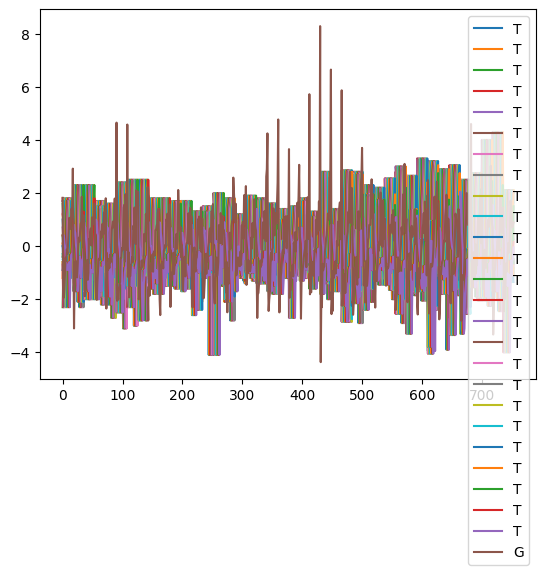

1

In [52]:
n = len(y)
t = range(n)
plt.plot(t,X,label = "T")
plt.plot(t,y,label = "G")
plt.legend()
plt.show()
1

In [40]:
y.to_numpy().max()

22.012717999999992

In [41]:
model.compute_mse_error_simple()

(149.27169647998105, 154.81365646279002)

In [42]:
list(zip(model.model.coef_,X.columns))

[(0.04503747890510381, 'temperature_change'),
 (0.08373658117468694, 'temperature_change_with_1_delay'),
 (0.03547795531976759, 'temperature_change_with_2_delay'),
 (0.1306448606186724, 'temperature_change_with_3_delay'),
 (-0.11601812478025401, 'temperature_change_with_4_delay'),
 (-0.10308086215587717, 'temperature_change_with_5_delay'),
 (-0.28262186508318543, 'temperature_change_with_6_delay'),
 (-0.3529342377976746, 'temperature_change_with_7_delay'),
 (-0.15054355600167482, 'temperature_change_with_8_delay'),
 (0.08120663510329965, 'temperature_change_with_9_delay'),
 (0.10664270574435791, 'temperature_change_with_10_delay'),
 (-0.03911274579368608, 'temperature_change_with_11_delay'),
 (-0.041620004558419355, 'temperature_change_with_12_delay'),
 (0.11481110621355137, 'temperature_change_with_13_delay'),
 (-0.07582562272140889, 'temperature_change_with_14_delay'),
 (0.18142178157278466, 'temperature_change_with_15_delay'),
 (-0.05579327848036443, 'temperature_change_with_16_dela

In [43]:
np.count_nonzero((df_row.loc[:,["is_good_pick"]] == 2).to_numpy())

41194